In [1]:
import rasterio
import rasterio.plot
import numpy as np
from osgeo import gdal_array
from scipy.signal import savgol_filter
from scipy.interpolate import pchip_interpolate, InterpolatedUnivariateSpline
import math
from scipy.optimize import minimize
from scipy.optimize import Bounds
import time
import matplotlib.pyplot as plt
%matplotlib inline


# 拟合

## 输入数据要求
- **时间序列影像**：`GeoTiff` 格式的时间序列影像（`*.tif`），其中每个波段表示不同日期的 NDVI 影像，第一个波段为这年第001天的影像，第二个波段为第017天的影像，以此类推。

默认输入文件名称：`<年份>_filtered.tif`

【注意】为了减小文件大小，输入的NDVI值被乘以$10000$，然后以`Int 16`整形存储。如果需要获得真实NDVI以及对应的RMSE指标，需要乘以比例系数$0.00001$. 比例系数不会影响物候期提取，可以不乘。

## 输出数据格式
- **SG滤波后的时间序列影像**：`GeoTiff` 格式的时间序列影像（`*.tif`），格式与输入数据要求一致，输出的文件名为 `<年份>.tif`，其中`<年份>`为影像的年份，格式如：2019, 2018等等。

### 注意
1. 由于影像文件较大，滤波然后保存文件可能会比较耗时。
2. 在运行此脚本前，请清空所有不必要的内存，否则无法分配内存运算，导致程序异常退出。

## 定义拟合函数
首先，定义 dobule logistic 拟合所需用到的函数：
- `double_logistic_array` 输入 double logistic 参数，以及日期的列表，给出每个时刻对应的拟合后的 NDVI 序列。
- `double_logistic` 输入 double logistic 参数，以及某个日期，给出当前日期的你和后的 NDVI 值。
- `genSynthObs` 输入 double logistic 参数、观测频率、噪声的标准差、云量，模拟一个增加噪声以后的 NDVI 时间序列。
- `rmse` 函数拟合的代价函数，输入 double logistic 参数、观测值、观测值对应的观测日期，返回 RMSE 值。
- `solver` 求解 double logistic 拟合参数。

double logistic 函数为：
$$\min \left[ \frac{c-d}{1+e^{k_1 \cdot (t - t_1)} } +d,  \frac{d-c}{1+e^{k_2 \cdot (t - t_2)} } +c  \right]$$

In [2]:
def double_logistic_array(params,timeArr):
    phenology=[]
    for time in timeArr:
        phenology.append(double_logistic(params,time))
    return np.array(phenology)

def double_logistic(params,time):
    """Generate a double logistic curve similar 
    to those of the MODIS phenology product
    
    k1   --- curvature parmeter for first half of season
    k2   --- curvature parmeter for second half of season
    t01  --- timing parmeter for first half of season
    t02  --- timing parmeter for second half of season
    c    --- minimum LAI/NDVI etc
    d    --- maximum LAI/NDVI etc
    
    time --- time valueto evaluate the function 
    """
    k1  =params[0]
    k2  =params[1]
    t01 =params[2]
    t02 =params[3]
    c   =params[4]
    d   =params[5]
    lgstc1=(c-d)/(1.+math.exp(k1*(time-t01)))+d    
    lgstc2=(d-c)/(1.+math.exp(k2*(time-t02)))+c
    return np.min([lgstc1,lgstc2])
    
def genSynthObs(params,freq=16,stddev=0.0,cloud=0.0):
    
    time_arr=[]
    synth_obs=[]
    for t in range(1,365,freq):
        if np.random.rand()<cloud:
            continue
        time_arr.append(t)
        obs=double_logistic(params,t)
        obs=obs+np.random.normal(0.,stddev)
        synth_obs.append(obs)
        
    return np.array(synth_obs),np.array(time_arr)


def rmse(params,obs,obs_time):
    model=double_logistic_array(params,obs_time)
    rmse_series = np.sqrt(np.sum((model-obs)**2)/float(len(obs_time)))
    return rmse_series
    
def solver(params,obs,obs_time,costFunction,bounds):
    #costGradient, costHessian=ad.gh(costFunction)
    return minimize(costFunction,\
                    params,\
                    args=(obs,obs_time),\
                    bounds=bounds,\
                    #method='L-BFGS-B',\
                    jac='2-point',\
                    options={'gtol': 1e-6})

In [ ]:
## 单点实验，测试性能
读取 2019 年滤波后的影像，然后选取坐标为 [3000,5000] 的时间序列，对其进行 double logistic 拟合。
然后将单个像素的拟合时间打印出来。（约 0.15 秒）

In [3]:

filtered_img_path = r'data/2019_filtered_int.tif'
filtered_img = gdal_array.LoadFile(filtered_img_path)

raw_img_path = r'data/2019.tif'
raw_img = gdal_array.LoadFile(raw_img_path)

#test_series = np.ndarray.transpose(filtered_img[:,60,35])
start = time.time()
test_series = filtered_img[:,3000,5000]
time_arr=np.arange(1, 365, 16)

params=np.zeros(6)
params[0]=0.2
params[1]=0.4
params[2]=120
params[3]=200
params[4]=np.min(test_series)
params[5]=np.max(test_series)

param_bounds = Bounds([0,0,50,210,0,0],[0.1,0.1,160,300,10000,10000])

phenology=double_logistic_array(params,time_arr)
#synth_obs, obs_times=genSynthObs(params,freq=16,stddev=0.05,cloud=0)

synth_obs = test_series #/ 10000
obs_times = time_arr

#print(obs_times)
    
s=solver(params,synth_obs,obs_times,rmse,param_bounds)
rmse_series = s.fun

retrieval=double_logistic_array(s.x,time_arr)
end = time.time()
print(end - start)
#plt.plot(obs_times, test_series / 10000, label="test")

0.1466372013092041


In [5]:
s

      fun: 421.2884458281575
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.39669800e-03,  3.73458862e-03,  8.27699894e-05, -2.44986883e-05,
       -2.73339270e-06,  9.69311198e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 462
      nit: 49
     njev: 66
   status: 0
  success: True
        x: array([4.17518771e-02, 4.41992793e-02, 1.24345228e+02, 2.74672910e+02,
       1.10530779e+03, 4.97715782e+03])

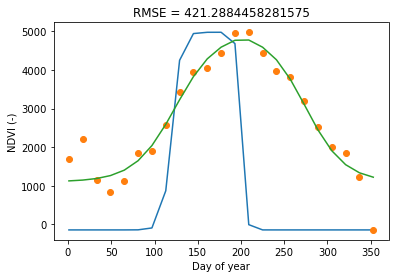

In [4]:
plt.plot(time_arr,phenology, label="Initial Guess")
    
plt.plot(obs_times,synth_obs,"o", label="obs")
plt.plot(time_arr,retrieval, label="retrieved")

plt.xlabel("Day of year")
plt.ylabel("NDVI (-)")
#plt.ylim([0,3.0])
plt.title('RMSE = ' + str(rmse_series))
#plt.show()
plt.savefig("phenology_example.png")

## Running on rasters

In [ ]:
# 读取滤波后的影像
filtered_img_path = r'data/2019_filtered_int.tif'
filtered_img = gdal_array.LoadFile(filtered_img_path)
[doy, img_ht, img_wd] = filtered_img.shape              # 影像的维度（日期数、宽、高）
param_num = 6       # double logistic 参数个数

#fitted_img = np.zeros(filtered_img.shape)
fitted_params = np.zeros((param_num, img_ht, img_wd))
param_bounds = Bounds([0,0,50,210,0,0],[0.1,0.1,160,300,10000,10000])

# 分配影像日期(DOY)
time_arr=np.arange(1, 365, 16)

# 开始计时
start = time.time()
for x in range(1,img_ht):
    # 打印进度信息，因为影像较大。
    if x%100 == 0:
        end = time.time()
        print(x, ' of ', img_ht, '\t', x/img_ht *100, '%\t Time elapsed: ', str(end - start) )
        
    for y in range(1,img_wd):
        series = filtered_img[:,x,y] # 获取原始影像时间序列

        # 如果序列全为 0，则不需要做拟合（研究区外）
        if np.count_nonzero(series) > 20:

            # Double logistic 拟合参数的初始猜测
            params=np.zeros(6)
            params[0]=0.2
            params[1]=0.4
            params[2]=120
            params[3]=250
            params[4]=np.min(series)
            params[5]=np.max(series)

            # 初始猜测参数的时间序列曲线
            phenology=double_logistic_array(params,time_arr)
            #synth_obs, obs_times=genSynthObs(params,freq=16,stddev=0.05,cloud=0)

            # 滤波后的观测时间序列曲线
            synth_obs = series #/ 10000
            obs_times = time_arr

            # 经过优化后的 double logiscit 参数值和 RMSE 值
            s=solver(params,synth_obs,obs_times,rmse,param_bounds)
            rmse_series = s.fun

            # double logistic 拟合后的时间序列
            #fitted_img[:,x,y]=double_logistic_array(s.x,time_arr)
            fitted_params[:,x,y] = s.x


In [ ]:
# 把滤波后的时间序列存储到新的影像中
    with rasterio.open(
        out_img_path,
        'w',
        driver='GTiff',
        height=fitted_params.shape[1],
        width=fitted_params.shape[2],
        count=fitted_params.shape[0],
        dtype=rasterio.float64, #存储数据精度为 float64,参数精度要求较高
        crs=src.crs,
        transform=src.transform,
    ) as dst:
        dst.write(fitted_params.astype(np.int16)) 